In [ ]:
# ! python3.9 -m pip install --upgrade --target='/home/ldoyle/packages' obspy

In [1]:
import h5py
import cv2
import os
from datetime import datetime
import matplotlib.dates as mdates
import numpy as np
from tqdm import tqdm
from matplotlib import gridspec
import matplotlib.pyplot as plt
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"

In [2]:
import glob


In [ ]:
# print(glob.glob('/home/**/*.csv',recursive=True))

In [3]:
smoothed_dat = np.load('gaussian_smoothed_11_2_2022_channels_7500_12500South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy')

## fk-filt

In [4]:
from numpy import fft
import numpy as np
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime

In [5]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"
file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5"
# file2 = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231214Z.h5"

f = h5py.File(path+file, 'r')
data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
f.close()

In [8]:
sliced_data = data[7500:12500,:]

In [64]:
fk_dat = np.fft.rfftn(sliced_data)

In [65]:
fk_dat

array([[ 7.51900422e+11+0.00000000e+00j,  3.33758725e+11-3.22831173e+11j,
         2.18056803e+11-1.95126126e+11j, ...,
        -1.12391456e+08+9.58515074e+04j, -1.12359940e+08+7.48739718e+04j,
        -1.12283189e+08+0.00000000e+00j],
       [ 2.99804394e+12+2.10741560e+12j, -1.58544477e+11-3.36461120e+10j,
        -8.44409201e+10-8.12474901e+10j, ...,
        -1.28239560e+08-6.01886254e+07j, -1.28224666e+08-6.01928704e+07j,
        -1.28198997e+08-6.02542305e+07j],
       [ 2.65807628e+12-1.71209168e+12j,  6.51719295e+11-9.74362176e+11j,
         2.37642452e+11-5.18836465e+11j, ...,
         1.06805309e+08+6.06946474e+07j,  1.06779247e+08+6.07353061e+07j,
         1.06766833e+08+6.07602684e+07j],
       ...,
       [ 4.67076798e+12+2.07984497e+12j,  8.36349640e+11-1.25062587e+12j,
         4.15221483e+11-4.26566437e+11j, ...,
        -7.49275210e+06+2.33277565e+08j, -7.54158130e+06+2.33287804e+08j,
        -7.61619490e+06+2.33268181e+08j],
       [ 2.65807628e+12+1.71209168e+12j,  1.

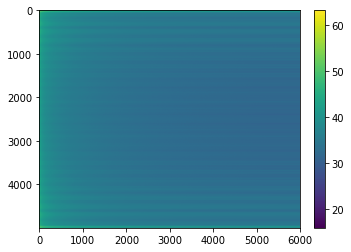

In [66]:
vmin=2500
vmax=np.amax(np.abs(fk_dat))
im = plt.imshow(np.log(np.abs(fk_dat)**2))#,vmin=vmin, vmax=vmax)
plt.colorbar(im, pad = 0.04)
plt.show()

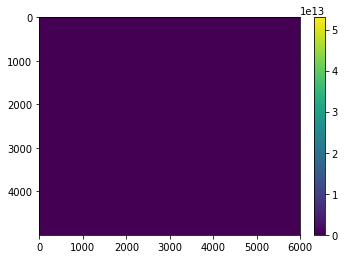

In [67]:
im = plt.imshow(np.imag(fk_dat),vmin=vmin, vmax=vmax)
plt.colorbar(im, pad = 0.04)
plt.show()

In [68]:
np.amax(np.abs(fk_dat))*(10**(-13))

5.296247063978412

In [69]:
np.amin(np.abs(fk_dat))

2993.862210145311

In [70]:
np.real(fk_dat)

array([[ 7.51900422e+11,  3.33758725e+11,  2.18056803e+11, ...,
        -1.12391456e+08, -1.12359940e+08, -1.12283189e+08],
       [ 2.99804394e+12, -1.58544477e+11, -8.44409201e+10, ...,
        -1.28239560e+08, -1.28224666e+08, -1.28198997e+08],
       [ 2.65807628e+12,  6.51719295e+11,  2.37642452e+11, ...,
         1.06805309e+08,  1.06779247e+08,  1.06766833e+08],
       ...,
       [ 4.67076798e+12,  8.36349640e+11,  4.15221483e+11, ...,
        -7.49275210e+06, -7.54158130e+06, -7.61619490e+06],
       [ 2.65807628e+12,  1.20383921e+11,  3.17512107e+10, ...,
         1.06726386e+08,  1.06755154e+08,  1.06766833e+08],
       [ 2.99804394e+12,  5.61281321e+11,  2.92244735e+11, ...,
        -1.28189890e+08, -1.28192314e+08, -1.28198997e+08]])

In [75]:
filt_fk = np.zeros(fk_dat.shape).astype(np.complex128)
shift_fk = fft.fftshift(fk_dat,1)
for i in range(fk_dat.shape[0]):
#     dig = np.amin()
    bound =i//6
    filt_fk[-i,3000-bound:3000+bound] = shift_fk[-i,3000-bound:3000+bound]
    if i<3000:
        filt_fk[-i,3000+i:] = shift_fk[-i,3000+i:]
        filt_fk[-i,:3000-i] = shift_fk[-i,:3000-i]

<ipython-input-76-35442f06997e>:3: RuntimeWarning: divide by zero encountered in log
  im = plt.imshow(np.log(np.abs(filt_fk)**2))#,vmin=vmin, vmax=vmax)


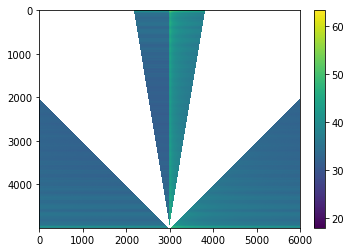

In [76]:
vmin=0
vmax=np.amax(np.abs(fk_dat))
im = plt.imshow(np.log(np.abs(filt_fk)**2))#,vmin=vmin, vmax=vmax)
plt.colorbar(im, pad = 0.04)
plt.show()

In [77]:
fk_inv = fft.irfftn(fft.ifftshift(filt_fk,1))

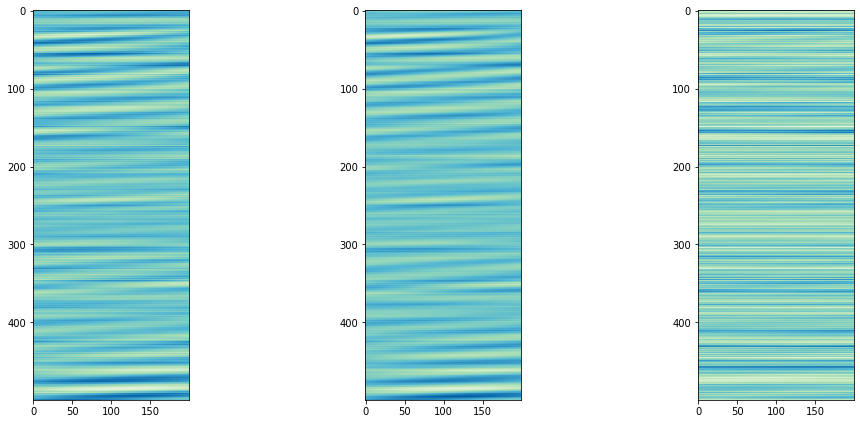

In [55]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize = (14,6))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
vmin=np.amin(sliced_data)
vmax=np.amax(sliced_data)
im = ax1.imshow(sliced_data[::10,:2000:10], vmin=vmin, vmax=vmax,
                cmap = 'GnBu')

im = ax2.imshow(filtered_data_unsure.T[::10,:2000:10], vmin=vmin, vmax=vmax,
                cmap = 'GnBu')
im = ax3.imshow(filtered_data_unsure.T[::10,:2000:10]-sliced_data[::10,:2000:10], #vmin=vmin, vmax=vmax,
                cmap = 'GnBu')
plt.show()

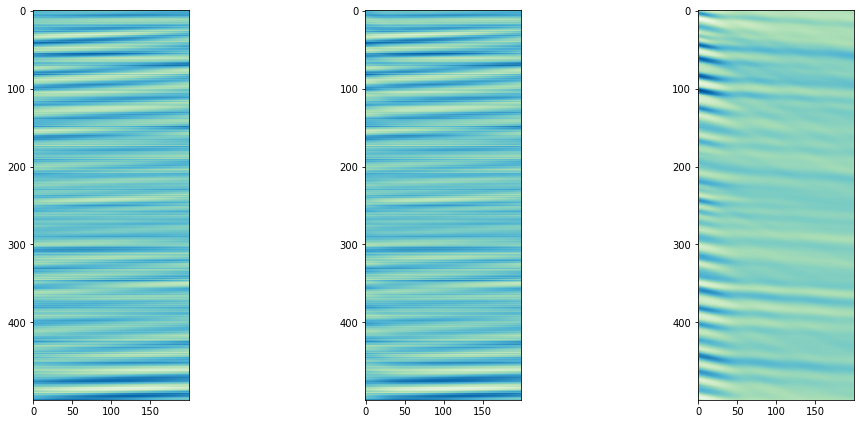

In [78]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize = (14,6))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
vmin=np.amin(sliced_data)
vmax=np.amax(sliced_data)
im = ax1.imshow(sliced_data[::10,:2000:10], vmin=vmin, vmax=vmax,
                cmap = 'GnBu')

im = ax2.imshow(fk_inv[::10,:2000:10], vmin=vmin, vmax=vmax,
                cmap = 'GnBu')
im = ax3.imshow(fk_inv[::10,:2000:10]-sliced_data[::10,:2000:10], #vmin=vmin, vmax=vmax,
                cmap = 'GnBu')
plt.show()

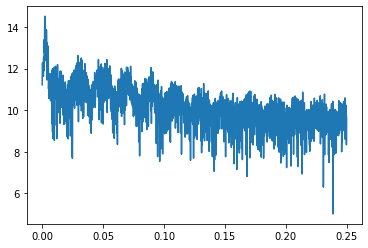

In [60]:
N=5000
yf1 = fft.fft(data[7500:12500,540])
yf3 = fft.rfft2(data[7500:12500,:])
xf = fft.fftfreq(N, 2)[:N//2]
plt.figure()
plt.plot(xf,np.log(2.0/N * np.abs(yf1[:N//2])))
#plt.xlim(0,0.2)
plt.show()


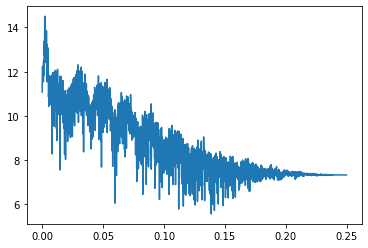

In [61]:
yf1 = fft.fft(filtered_data_unsure.T[:,540])
plt.figure()
plt.plot(xf,np.log(2.0/N * np.abs(yf1[:N//2])))
#plt.xlim(0,0.2)
plt.show()

In [62]:
smoothed_dat = np.load('gaussian_smoothed_11_2_2022_channels_7500_12500South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy')

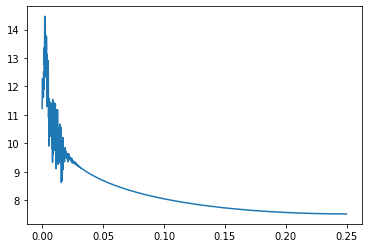

In [63]:
yf1 = fft.fft(smoothed_dat[:,540])
plt.figure()
plt.plot(xf,np.log(2.0/N * np.abs(yf1[:N//2])))
#plt.xlim(0,0.2)
plt.show()

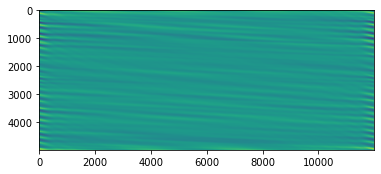

In [115]:
plt.imshow(sliced_data-fk_inv)
plt.show()

## Seems to work exceptionally

In [9]:
from obspy.signal import filter as obsfilt

In [10]:
lp_dat = obsfilt.lowpass(sliced_data.T, 20, 200, corners=1, zerophase=True)

In [80]:
np.amax(np.abs(filtered_data_unsure.T-sliced_data))

8185893.150049139

In [85]:
residuals1 = (filtered_data_unsure.T.flatten()-sliced_data.flatten())
residuals2 = (fk_inv.flatten()-sliced_data.flatten())

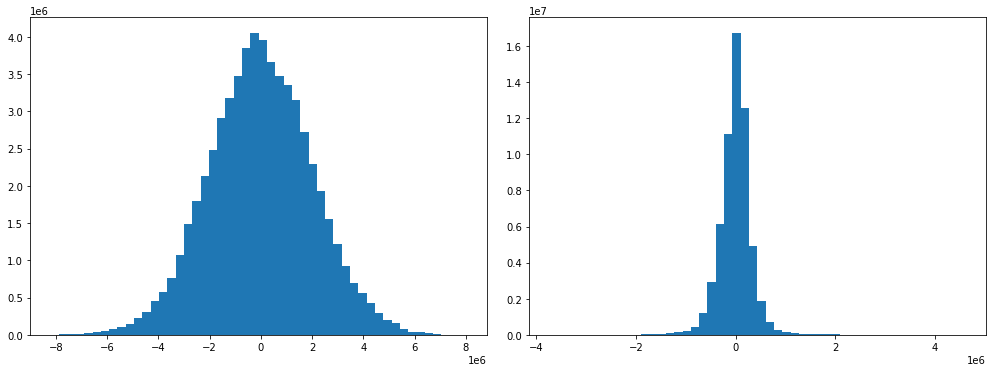

In [86]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize = (14,5))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
ax1.hist(residuals1,bins=50)
ax2.hist(residuals2,bins=50)
plt.show()

In [26]:
working_dat = lp_dat.T#[::10,::10]
working_dat = working_dat/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[1],working_dat.shape[0],1)

In [31]:
print(np.amax(working_dat))
print(np.amin(working_dat))

3.886546563676792
-4.234663264070028


In [32]:
working_dat.shape

(12000, 5000, 1)

In [33]:
dt=1.
x = np.arange(working_dat.shape[1])

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=4,
    spatial_grid=x,
    include_bias=True,
    is_uniform=True,
    periodic=True
)

optimizer = ps.SR3(threshold=1e-9, alpha=1e-5, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

In [34]:
print("Ensemble SR3 ")
model.print()

Ensemble STLSQ 
(x0)' = 0.005 x0_1 + 0.007 x0_111


In [35]:
dt=1.
x = np.arange(working_dat.shape[1])

optimizer = ps.STLSQ(threshold=10**(-5), alpha=1e-5, max_iter=20)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


library_ensemble_coefs = model.coef_list
mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

print("Ensemble STLSQ ")
model.print()

Ensemble STLSQ 
(x0)' = 0.005 x0_1 + 0.007 x0_111
